In [143]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, linalg as sla
from math import pi
import magnetic_boundaries as mb
from scipy.linalg import eig, eigh

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

Here we need a rectangle with periodic boundary conditions in one direction. We must make sure that the Peierls phases are periodic...right?
Does this mean we can only have an integer number of flux quanta and Landau gauge? Not really, We can even just take the Landau gauge with A parallel to the ribbon That is always trivially translationally invariant. We already did this, our good thing now is that we can use boundary conditions to compensate the chirality of the zero mode. I guess its is going to have some problems.

Text(0.5, 1.0, 'Lattice')

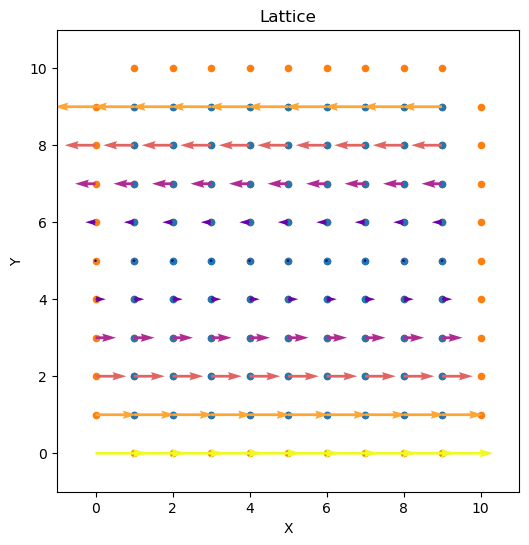

In [29]:
Lx = 10
Ly = 10
flux_quanta = 50
magnetic_field = 2*pi/(Lx*Ly)*flux_quanta
fluxes = magnetic_field*np.ones((Ly,Lx))
a_e, a_n = mb.vector_potential(Lx,Ly,fluxes, gauge = "Landau")

parameters = dict(
    Lx = Lx,
    Ly = Ly,
    theta = 0,
    a_e = a_e,
    a_n = a_n,
    mass = 0
)

Phi, H, P, deleted_indices, spinup_shape, spindown_shape = mb.operators_rectangle(parameters, return_shape = True)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
# Define a grid of points
x = np.linspace(0, Lx-1, Lx) 
y = np.linspace(0, Ly-1, Ly)  
X, Y = np.meshgrid(x, y)    # Create a meshgrid for plotting
ax.quiver(X, Y, a_e[:-1,:], a_n[:,:-1],np.sqrt(a_e[:-1,:]**2 + a_n[:,:-1]**2),cmap="plasma",zorder = 2) #The right and top edges are left out of the plot
ax.scatter(spinup_shape[0],spinup_shape[1], s = 20)
ax.scatter(spindown_shape[0],spindown_shape[1], s = 20,zorder=-1)
#ax.imshow(fluxes,extent=[0, Lx, 0, Ly],zorder = -2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-1,Lx+1)
ax.set_ylim(-1,Ly+1)
ax.set_aspect('equal')
ax.set_title('Lattice')

In [2]:
def operators_ribbon(parameters, return_shape = False):
    '''
    Returns operators Phi, H and P for a ribbon in x direction
    geometry boundary conditions are independent on each side.
    -parameters: dict
    -return_shape = bool
    Returns
    -Phi: csc_matrix (2*Lx*Ly-2*(Lx+Ly-2)-4,2*Lx*Ly-2*(Lx+Ly-2)-4)
    -H: csc_matrix (2*Lx*Ly-2*(Lx+Ly-2)-4,2*Lx*Ly-2*(Lx+Ly-2)-4)
    -P: csc_matrix (2*Lx*Ly-2*(Lx+Ly-2)-4,2*Lx*Ly-2*(Lx+Ly-2)-4)
    -indices_to_delete: list
    '''
    #The parameters dictionary must have the following key,value pairs
    theta_bot = parameters['theta_bot'] #float in (-pi,pi] Boundary condition angle on the bottom
    theta_top = parameters['theta_top'] #float in (-pi,pi] Boundary condition angle on the top
    kx = parameters['kx']       # float in (-pi/pi] wavenumber in x direction
    gap = parameters['mass']    #float Mass gap
    Lx = parameters['Lx']       #int Number of lattice sites in x direction
    Ly = parameters['Ly']       #int Number of lattice sites in y direction
    Nx = Lx #######Notice the difference here with respect to the rectangle
    Ny = Ly+1
    a_e = parameters['a_e']   #ndarray(Ly+1,Lx) Peierls phases to the right 
    a_n = parameters['a_n']   #ndarray(Ly, Lx+1) Peierls phases up
    #Attach zeros to the Peierls phases to fix their size. Only to the up ones this time.
    a_n = np.concatenate([a_n,np.zeros((1,Lx+1))],axis = 0)

    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []

    
    for i in range(Nx*Ny):
        y = i//Nx
        x = i%Nx
                
        #Phases
        phase_e = np.exp(1j*a_e[y,x])*np.exp(-1j*kx*Nx*(1 if x==Nx-1 else 0)) #We added the Bloch phase for x == Nx-1
        phase_n = np.exp(1j*a_n[y,x])
        
        row_Tx += [i]
        col_Tx += [((x+1)%Nx) + y*Nx]
        data_Tx += [phase_e] ## Here we keep periodic boundary conditions
        
        row_Ty += [i]
        col_Ty += [x + ((y+1)%Ny)*Nx]
        data_Ty += [phase_n*(1-(y//(Ny-1)))] ################## Open boundaries in y direction
        
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2
       
    mass = scipy.sparse.spdiags(gap*np.ones(Nx*Ny), 0, Nx*Ny, Nx*Ny, format = "csc")
    M = scipy.sparse.kron(csc_matrix(sigma_z), mass, format = "csc")
    
    H_0 = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")

    H = H_0 + Phi.H@M@Phi
        
    # Unitary transformation on the edges. Let us build a rotation matrix that acts on a single site.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a (theta,phi) orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = int(site[0] + site[1]*Nx)
        spindown = int(site[0] + site[1]*Nx + Nx*Ny)
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
        
    # Now rotate the spins on the edge
    def get_index(x,y,s):
        '''Returns the index of the orbital in x,y with spin s'''
        return int(Nx*Ny*s + Nx*y + x)

    edge_points, normal_angles = generate_ribbon(Lx, Ly)
    # The parameter that we need for the spin rotation is the projection of the boundary spin o the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
    
    indices_to_delete = []
    ##### We can make theta also an array in order to assign different values to each boundary
    theta = np.concatenate((theta_top*np.ones(Lx), theta_bot*np.ones(Lx)))
    for point in zip(edge_points[0], edge_points[1], theta, boundary_spin_projections):
        
        #rotate
        rotation = spin_rotation([point[0],point[1]], point[2], point[3]) 
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation
        
        #book index to delete
        indices_to_delete.append(get_index(point[0],point[1],1))

    #Now we also have to delete the outer part
    amount_out = 0
    def discriminant(x,y):
        return y>0 and y<Ly
        
    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    for x,y in zip(X.ravel(),Y.ravel()):
        if not discriminant(x,y) and  get_index(x,y,1) not in indices_to_delete:
            indices_to_delete.append(get_index(x,y,0))
            indices_to_delete.append(get_index(x,y,1))
            amount_out += 1

            
    # Transforming the sparse matrix into dense to delete spins
    H_aux = H.toarray()
    Phi_aux = Phi.toarray()
   
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    H = csc_matrix(H_aux)
    Phi = csc_matrix(Phi_aux)
    P = Phi.H@Phi

    if return_shape:
        inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)
        inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
        inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
        inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)
    
        return Phi, H, P, indices_to_delete, (inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:]), (inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out])
    else:
        return Phi, H, P, indices_to_delete

In [3]:
def generate_ribbon(Lx, Ly, plot_shape = False):
    '''Generates the set of points in the grid closest to a ribbon with sides Lx and Ly and the angle of the normal vector.
    The boundaries are only in y direction. The ribbon is infinite in x direction.
    - Lx: int
    - Ly: int
    - plot_shape: bool
    Returns
    - boundary_points: ndarray (2,2*Lx)
    - normal_angles: ndarray (2*Lx)'''

    x2 = np.linspace(Lx-1,-1, Lx, endpoint = False)
    y2 = Ly*np.ones(Lx)
    angles2 = (pi/2)*np.ones(Lx)
    
    x4 = np.linspace(0,Lx, Lx, endpoint = False)
    y4 = np.zeros(Lx)
    angles4 = -(pi/2)*np.ones(Lx)

    x = np.concatenate((x2,x4))
    y = np.concatenate((y2,y4))

    
    normal_angles = np.concatenate((angles2,angles4))
    boundary_points = np.stack((x,y))
    
    return boundary_points, normal_angles

Text(0.5, 1.0, 'Lattice')

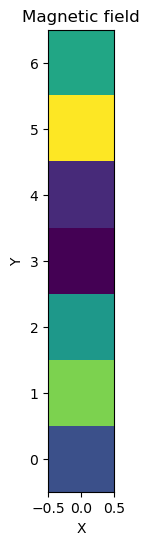

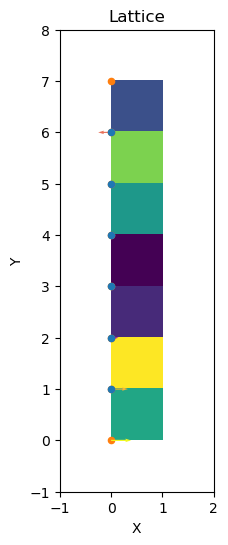

In [125]:
Lx = 1
Ly = 7
fluxes = np.random.rand(Ly,Lx)/1000
a_e, a_n = mb.vector_potential(Lx,Ly,fluxes, gauge = "Landau")

parameters = dict(
    Lx = Lx,
    Ly = Ly,
    theta_top = -(pi/2)*(0/100),
    theta_bot = -(pi/2)*(0/100),
    a_e = a_e,
    a_n = a_n,
    kx = 0,
    mass = 0
)

Phi, H, P, deleted_indices, spinup_shape, spindown_shape = operators_ribbon(parameters, return_shape = True)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
# Define a grid of points
x = np.linspace(0, Lx-1, Lx) 
y = np.linspace(0, Ly-1, Ly)  
X, Y = np.meshgrid(x, y)    # Create a meshgrid for plotting
ax.quiver(X, Y, a_e[:-1,:], a_n[:,:-1],np.sqrt(a_e[:-1,:]**2 + a_n[:,:-1]**2),cmap="plasma") #The right and top edges are left out of the plot
ax.scatter(spinup_shape[0],spinup_shape[1], s = 20)
ax.scatter(spindown_shape[0],spindown_shape[1], s = 20,zorder=-1)
ax.imshow(fluxes,extent=[0, Lx, 0, Ly],zorder = -2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-1,Lx+1)
ax.set_ylim(-1,Ly+1)
ax.set_aspect('equal')
ax.set_title('Lattice')

# Now let us plot bands

In [48]:
def make_bands_x(parameters, number_of_bands = int(20), number_of_points = int(101), kmin = -pi, kmax = pi):
    '''Calculate bands in x direction.'''

    momenta = np.linspace(kmin,kmax, num = number_of_points)
    bands = np.zeros((number_of_points,number_of_bands))
    #bands = []
    
    #Solve generalised eigenproblem for all kx
    for j, kx in enumerate(momenta):
        parameters['kx'] = kx
        Phi, H, P, deleted_indices = operators_ribbon(parameters)
        bands[j] = sla.eigsh(H, M=P, k = number_of_bands, tol = 1e-7, sigma = 0.0000001, which = 'LM',return_eigenvectors = False)
        #lam, v = eig(H.toarray(), P.toarray())
        #bands.append(np.array(lam))

    return momenta, bands

(-3.141592653589793, 3.141592653589793)

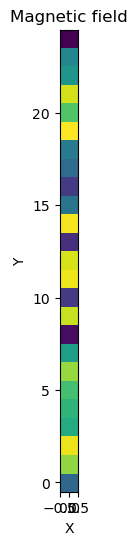

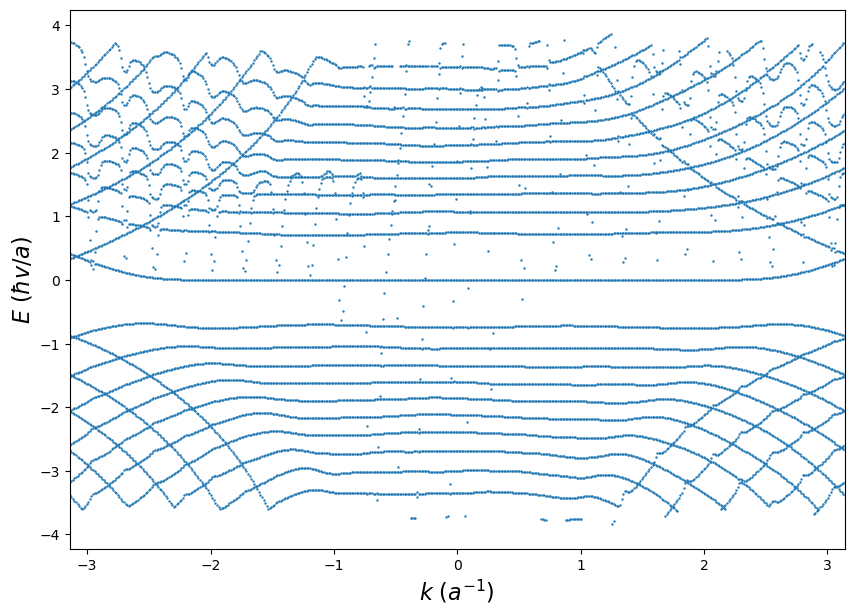

In [160]:
Lx = 1
Ly = 25
#fluxes = 0*np.random.rand(Ly,Lx)/1000
quanta = 1
noise = 3
fluxes = quanta*2*pi/(Lx*Ly)*np.ones((Ly,Lx)) + noise*(np.random.rand(Ly,Lx)-0.5)/(Lx*Ly)
fluxes = fluxes - (np.sum(fluxes)-2*pi*quanta)/(Lx*Ly)

mb.plot_B(fluxes)
a_e, a_n = mb.vector_potential(Lx,Ly,fluxes, gauge = "Landau")

parameters = dict(
    Lx = Lx,
    Ly = Ly,
    theta_top = pi/2,
    theta_bot = pi/2,
    a_e = a_e,
    a_n = a_n,
    mass = 0
)

nbands = 22
kmin = -pi/Lx
kmax = pi/Lx
momenta, bands = make_bands_x(parameters,number_of_bands = nbands, number_of_points = int(501),kmin = kmin, kmax = kmax)
bands = np.array(bands)

fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111)
for i in range(nbands):
    ax.scatter(momenta, bands[:,i], c = 'C0', s = 0.5)
ax.set_ylabel(r"$E$ $(\hbar v/a)$",fontsize = 16)
ax.set_xlabel(r"$k$ $(a^{-1})$",fontsize = 16)
ax.set_xlim(kmin,kmax)
#ax.set_ylim(-10,10)

Now plot eigenstates. Uff it is hard because they have to be reshaped....

In [140]:
def make_states(parameters, number_of_bands = int(20)):
    '''Calculate eigenstates.'''
    theta_bot = parameters['theta_bot'] #float in (-pi,pi] Boundary condition angle on the bottom
    theta_top = parameters['theta_top'] #float in (-pi,pi] Boundary condition angle on the top
    Nx = Lx
    Ny = Ly+1
    #Solve generalised eigenproblem 
    Phi, H, P, deleted_indices = operators_ribbon(parameters)
    eigenvalues, eigenvectors = sla.eigsh(H, M=P, k = number_of_bands, tol = 1e-7, sigma = 0.0000001, which = 'LM',return_eigenvectors = True)

    #Refill with zeros the deleted spins
    states = np.zeros((2*Nx*Ny,number_of_bands),dtype = complex)
    count = 0
    for index in range(2*Nx*Ny):
        if index not in deleted_indices:
            states[index] = (Phi@eigenvectors)[index-count]
        else:
            count += 1

    #Now make sure they are orthogonal
    overlaps = states.conjugate().transpose()@states
    ##The overlap can only be non-zero for degenerate states
    degenerate_indices = []
    bulk_indices = []    
    for i in range(overlaps.shape[0]):
        sorted = np.flip(np.sort(np.abs(overlaps[i])))
        if sorted[1]/sorted[0]<0.1: #This threshold (0.1) is a bit arbitrary
            bulk_indices.append(i)
        else:
            degenerate_indices.append(i)

    overlaps_deg = np.delete(overlaps, bulk_indices, axis=0)
    overlaps_deg = np.delete(overlaps_deg, bulk_indices, axis=1)
    overlaps_bulk = np.delete(overlaps, degenerate_indices, axis=0)
    overlaps_bulk = np.delete(overlaps_bulk, degenerate_indices, axis=1)

    states_deg = np.delete(states, bulk_indices, axis=1)
    states_bulk = np.delete(states, degenerate_indices, axis=1)

    evalues, orthogonal_coeff = np.linalg.eigh(overlaps_deg)
    orthogonal = np.append(states_deg@orthogonal_coeff, states_bulk , axis=1) #### These are finally the orthogonalised states
    norm = np.sqrt(np.diag(np.abs(orthogonal.conjugate().transpose()@orthogonal)))
    states = orthogonal/norm[None,:]
    
    # Rebuild state
    def spin_rotation(site, theta, phi):
        '''Returns a unitary transformation matrix that rotates the spin site to a theta,phi orientation'''
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = int(site[0] + site[1]*Nx)
        spindown = int(site[0] + site[1]*Nx + Nx*Ny)
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
        
    # We need to generate again the shape in order to refill the deleted sites
    edge_points, normal_angles = generate_ribbon(Lx, Ly)
    # The parameter that we need for the spin rotation is the projection of the boundary spin on the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2

     # Rotate back the spins on the edge
    theta = np.concatenate((theta_top*np.ones(Lx), theta_bot*np.ones(Lx)))
    for point in zip(edge_points[0], edge_points[1], theta, boundary_spin_projections):
        #rotate
        rotation = spin_rotation([point[0],point[1]], point[2], point[3]) 
        states = rotation@states

    ### Reshape
    states_shaped = np.reshape(states.flatten('F'), newshape = (number_of_bands,2,Ny,Nx), order = 'C')

    ### Assign again energies
    energies = np.zeros(number_of_bands)
    for i in range(number_of_bands):
        if i in degenerate_indices:
            energies[i] = 0
        else:
            energies[i] = eigenvalues[i]

    return energies, states_shaped, degenerate_indices

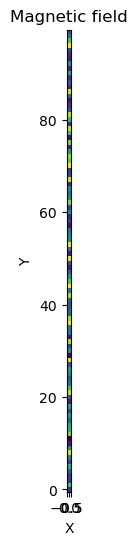

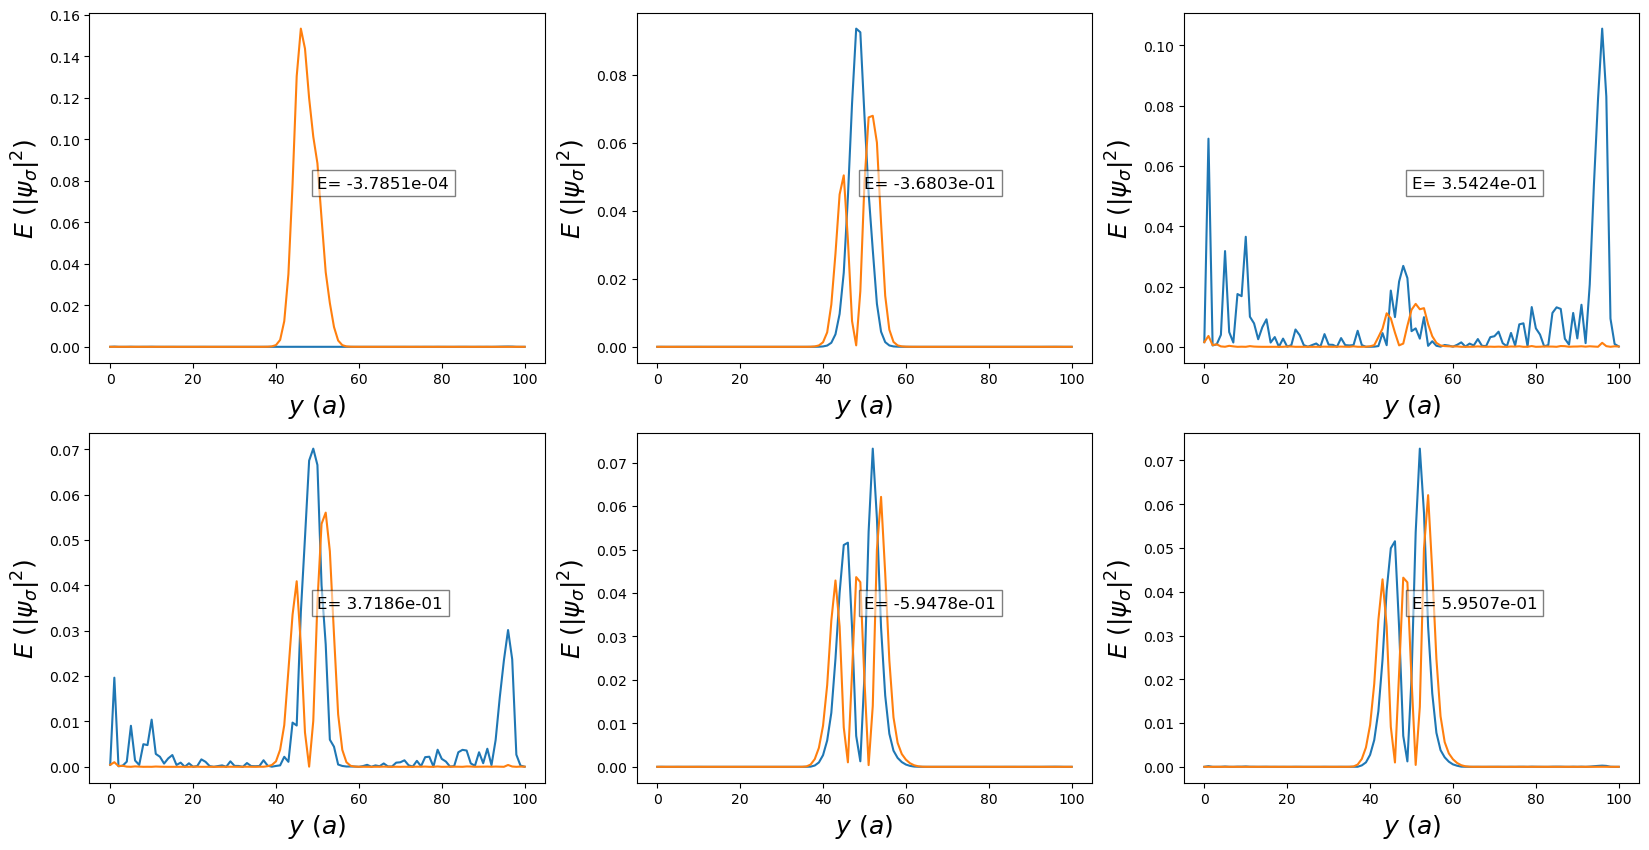

In [171]:
Lx = 1
Ly = 100
#fluxes = 0*np.random.rand(Ly,Lx)/1000
quanta = 1
noise = 30
fluxes = quanta*2*pi/(Lx*Ly)*np.ones((Ly,Lx)) + noise*(np.random.rand(Ly,Lx)-0.5)/(Lx*Ly)
fluxes = fluxes - (np.sum(fluxes)-2*pi*quanta)/(Lx*Ly)

mb.plot_B(fluxes)
a_e, a_n = mb.vector_potential(Lx,Ly,fluxes, gauge = "Landau")

parameters = dict(
    Lx = Lx,
    Ly = Ly,
    theta_top = pi/2,
    theta_bot = pi/2,
    a_e = a_e,
    a_n = a_n,
    mass = 0,
    kx = 0.01
)

nbands = 22
energies, states, idx = make_states(parameters,number_of_bands = nbands)

#PLOT
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()
number_of_bands = 6
for i in range(number_of_bands):
    probability_density  = np.sum(np.abs((states[i]))**2,axis = 0)
    spin_up_density  = np.abs((states[i,0]))**2
    spin_down_density  = np.abs((states[i,1]))**2    
    
    axs[i].plot(spin_up_density, c = "C0")
    axs[i].plot(spin_down_density, c = "C1")
    # axs[i].plot(np.arange(Ly-3),  spin_up_density[2:-2], c = "C0")
    # axs[i].scatter(np.arange(Ly-3),  spin_up_density[2:-2], c = "C0")
    # axs[i].plot(np.arange(Ly-3),  spin_down_density[2:-2], c = "C1")
    # axs[i].scatter(np.arange(Ly-3),  spin_down_density[2:-2], c = "C1")
    axs[i].set_ylabel(r"$E$ $(|\psi_\sigma|^2)$",fontsize = 18)
    axs[i].set_xlabel(r"$y$ $(a)$",fontsize = 18)
   
    formatted_number = f"{energies[i]:.4e}"
    axs[i].text(0.5, 0.5, "E= "+str(formatted_number), transform=axs[i].transAxes,
            fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

(-3.141592653589793, 3.141592653589793)

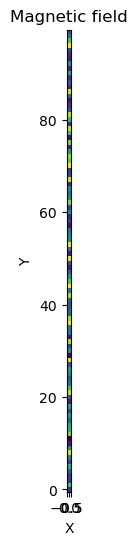

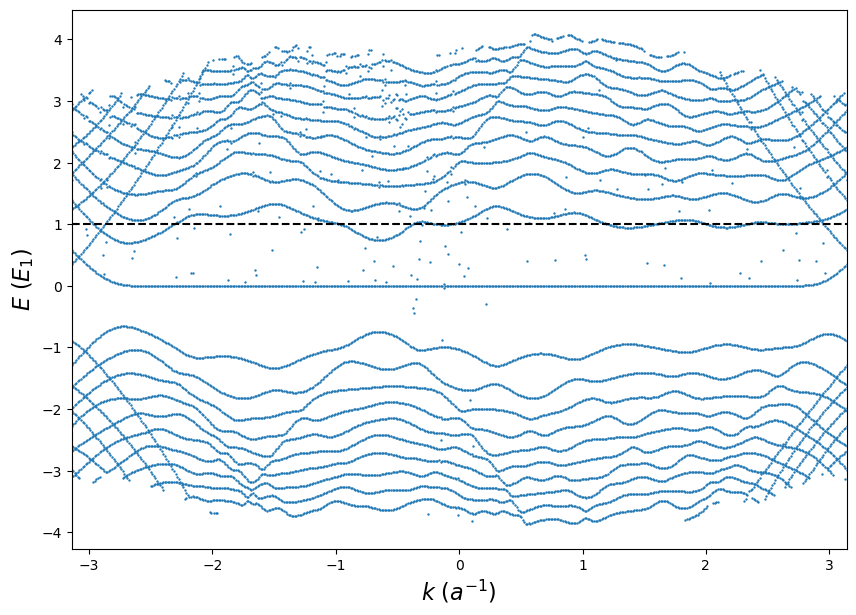

In [172]:
# Lx = 1
# Ly = 25
# #fluxes = 0*np.random.rand(Ly,Lx)/1000
# quanta = 1
# noise = 3
# fluxes = quanta*2*pi/(Lx*Ly)*np.ones((Ly,Lx)) + noise*(np.random.rand(Ly,Lx)-0.5)/(Lx*Ly)
# fluxes = fluxes - (np.sum(fluxes)-2*pi*quanta)/(Lx*Ly)

mb.plot_B(fluxes)
a_e, a_n = mb.vector_potential(Lx,Ly,fluxes, gauge = "Landau")

# parameters = dict(
#     Lx = Lx,
#     Ly = Ly,
#     theta_top = pi,
#     theta_bot = pi,
#     a_e = a_e,
#     a_n = a_n,
#     mass = 0
# )

nbands = 22
kmin = -pi/Lx
kmax = pi/Lx
momenta, bands = make_bands_x(parameters,number_of_bands = nbands, number_of_points = int(501),kmin = kmin, kmax = kmax)
bands = np.array(bands)

fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111)
for i in range(nbands):
    ax.scatter(momenta, bands[:,i]/np.sqrt((4*pi*quanta/Lx/Ly)), c = 'C0', s = 0.5)
ax.axhline(1,c = 'k',ls = '--')
#ax.set_ylabel(r"$E$ $(\hbar v/a)$",fontsize = 16)
ax.set_ylabel(r"$E$ $(E_1)$",fontsize = 16)
ax.set_xlabel(r"$k$ $(a^{-1})$",fontsize = 16)
ax.set_xlim(kmin,kmax)
#ax.set_ylim(-10,10)

### Now let us think.

It seems that things are more or less reasonable. I should think about whether this matches what would be expected. I would like to look at:
 - Bands for different field strengths, masses, Lxs. **Boundary conditions**
 - Bands when we include noise for different noise quanta through the system and Lxs
 - Eigenstates for for different field strengths, masses, Lxs. **Boundary conditions**. Here I should pay attention to how many edge modes and zero modes I expect.
 - Then repeat for a finite system

Do it in testing